<a href="https://colab.research.google.com/github/bilgin-kocak/fenics-tutorials-anders-logg/blob/master/Exercise_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 4: Solving Time-Dependent Problems
![image.png](attachment:image.png)

In this exercise, we will solve the following system of nonlinear advection-diffusion-reaction equations with FEniCS:

\begin{alignat}{2}
\frac{\partial u_1}{\partial t}+\beta\cdot\nabla u_1-\epsilon\Delta u_1 &= f_1-K u_1 u_2^2  \quad && \text{in } \Omega \\
\frac{\partial u_2}{\partial t}+\beta\cdot\nabla u_2-\epsilon\Delta u_2 &= f_2-2K u_1 u_2^2 \quad && \text{in } \Omega \\
u_1 = u_2 &= 0 \quad && \text{at } t = 0 \\
-\partial_n u_1 = -\partial_n u_2 &= 0 \quad && \text{on } \partial\Omega
\end{alignat}

This a model of the chemical reaction $A + 2B \rightarrow C$ where $u_1 = [A]$ is the concentration of $A$ and $u_2 = [B]$ is the concentration of $B$. Both $A$ and $B$ are being continuously added to the system through the source terms $f_1$ and $f_2$, and mixed through diffusion (diffusivity $\epsilon$) and advection (velocity $\beta$).

We will use the following data:

* $\Omega$ is the unit disc
* $\epsilon = 0.1$
* $\beta(x, y) = 5(-y, x)$
* $K = 10$
* $f_1(x, y) = \exp(-50((x + 0.75)^2 + y^2))$
* $f_2(x, y) = \exp(-50((x - 0.75)^2 + y^2))$
* 500 time steps of size $\Delta t = 0.01$

For hints and more reading on how to solve this problem in FEniCS, see the [section on solving systems of advection–diffusion–reaction equations](https://fenicsproject.org/pub/tutorial/html/._ftut1010.html#ftut1:reactionsystem) in the [FEniCS Tutorial](https://fenicsproject.org/tutorial/).

## Importing FEniCS
The first thing we need to do is to import FEniCS. We will also need to import the meshing library `mshr`.

In [ ]:
# Installing and Importing Fenics
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
try:
    from fenics import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from fenics import *; from mshr import *
    
dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

## Initializing notebook plotting
When running in a Jupyter notebook, a special line is necessary to show FEniCS plots in the notebook.

In [ ]:
%matplotlib inline

## Creating the mesh
To create the mesh, use a unit circle geometry and generate a mesh with resolution 16.

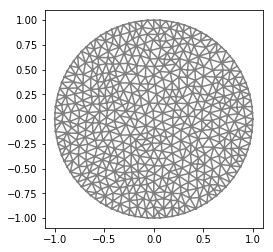

In [ ]:
C = Circle(Point(0,0), 1)
mesh = generate_mesh(C,16)
plot(mesh)

## Defining the finite element function space
When we have created the mesh, we can define the finite element function space. Since we will be solving a system of equations (for $u_1$ and $u_2$), we create a $P_1$ *vector* function space. Note that we add an additional argument to specify that we want two components.

In [ ]:
# using mesh, function type, degree, how many component
V = VectorFunctionSpace(mesh, "P", 1, 2)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


## Defining trial and test functions
For a vector function space (or more generally a *mixed* function space), functions as well as trial and test functions can be accessed via the `split` operator. Since we are solving a time-dependent problem, we also need to define functions for the values computed in the previous time step. We call the functions to be computed `u1` and `u2` and the values from the previous time step `u1n` and `u2n`.

In [ ]:
u = Function(V)
un = Function(V)
v = TestFunction(V)

u1, u2 = split(u)
u1n, u2n = split(un)
v1, v2 = split(v)

In [ ]:
# Or
v1, v2 = TestFunctions(V)

## Defining the variational problem
To solve the time-dependent problem, we discretize in time using the backward Euler method, which amounts to replacing the time derivatives with simple difference quotients $(u_i^{n+1} - u_i^n) / \Delta t$ and otherwise replacing the solution variables with the value at time $t_{n+1}$. As a result, we obtain the following finite element variational problem: Find $(u_1^{n+1}, u_2^{n+1}) \in V$ such that
\begin{align}
  &\int_{\Omega} \Delta t^{-1} (u_1^{n+1} - u_1^n) v_1 +
                \beta \cdot \nabla u^{n+1}_1 \, v_1 +
                \epsilon \nabla u^{n+1}_1 \cdot \nabla v_1 \,\mathrm{d}x \\
  +&
  \int_{\Omega} \Delta t^{-1} (u_2^{n+1} - u_2^n) v_2 +
                \beta \cdot \nabla u^{n+1}_2 \, v_2 +
                \epsilon \nabla u^{n+1}_2 \cdot \nabla v_2 \,\mathrm{d}x \\
  -&
  \int_{\Omega} f_1 v_1 + f_2 v_2 
               -K u^{n+1}_1 (u^{n+1}_2)^2 \, v_1  
               -2K u^{n+1}_1 (u^{n+1}_2)^2 \, v_2 \,\mathrm{d}x = 0.
\end{align}
for all $(v_1, v_2) \in V$.

This can be expressed in FEniCS by defining the nonlinear form $F(u_1, u_2; v_1, v_2)$ and solving $F(u_1, u_2; v_1, v_2) = 0$ for all $(v_1, v_2) \in V$.

Use a FEniCS `Constant` to define the time step (`k = Constant(dt)`) in the variational problem. This avoids recompilation of the variational form if the time step is changed.

In [ ]:
eps = Constant(0.1)
dt = 0.01
k = Constant(dt)
K = Constant(10)

x = SpatialCoordinate(mesh)
beta = as_vector((-5.0*x[1], 5.0*x[0])) # Or you can use expression

f1 = Expression('exp(-50.0*(pow(x[0]+0.75, 2)+ pow(x[1], 2)))', degree=2)
f2 = Expression('exp(-50.0*(pow(x[0]-0.75, 2)+ pow(x[1], 2)))', degree=2)

F = (((u1- u1n)/k)*v1 + dot(beta, grad(u1))*v1 + \
    eps*dot(grad(u1), grad(v1)))*dx +\
    (((u2- u2n)/k)*v2 + dot(beta, grad(u2))*v2 + \
    eps*dot(grad(u2), grad(v2)))*dx +\
    - (f1*v1 +f2*v2 - K*u1*u2**2*v1 - 2*K*u1*u2**2*v2)*dx

## Saving the solution to file
To save the time series to file, we create two VTK files that we can write to in each time step. Note that we will be computing the *mixed* (vector) function `u` so we will need to split the computed solution into two components in each time step using `u.split()`.

In [ ]:
file_u1 = File('exercise4/u1.pvd')
file_u2 = File('exercise4/u2.pvd')

## Time-stepping
The time-dependent problem is solved by time-stepping over a sequence of time steps and solving the nonlinear variational problem defined above in each time step and at the end of each time step assigning the newly computed values of `u` to the `un` variable.

In [ ]:
num_steps = 100
t = 0.0
for n in range(num_steps):
    # Update current time
    t += dt
    print("t = ", t)
    
    # Solve variational problem
    solve(F == 0, u)
    
    # Save solution to file
    _u1, _u2 = u.split()
    file_u1 << _u1
    file_u2 << _u2
    
    # Update previous solution
    un.assign(u)

t =  0.01
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
t =  0.02
t =  0.03
t =  0.04
t =  0.05
t =  0.060000000000000005
t =  0.07
t =  0.08
t =  0.09
t =  0.09999999999999999
t =  0.10999999999999999
t =  0.11999999999999998
t =  0.12999999999999998
t =  0.13999999999999999
t =  0.15
t =  0.16
t =  0.17
t =  0.18000000000000002
t =  0.19000000000000003
t =  0.20000000000000004
t =  0.21000000000000005
t =  0.22000000000000006
t =  0.23000000000000007
t =  0.24000000000000007
t =  0.25000000000000006
t =  0.26000000000000006
t =  0.2700000000000001
t =  0.2800000000000001
t = 

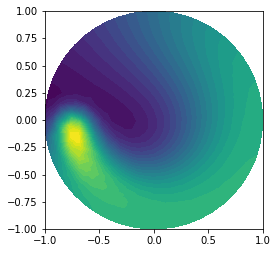

In [ ]:
plot(_u1)

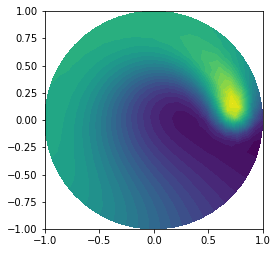

In [ ]:
plot(_u2)